<a href="https://colab.research.google.com/github/Ashi743/pytorch/blob/main/optimization_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(40)

In [2]:
#check device
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

100%|██████████| 68.8M/68.8M [00:00<00:00, 79.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [6]:
import os
import zipfile

In [7]:
for filename in os.listdir(path):
  print(filename)
  print(os.path.join(path, filename))

train-labels-idx1-ubyte
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/train-labels-idx1-ubyte
t10k-labels-idx1-ubyte
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/t10k-labels-idx1-ubyte
train-images-idx3-ubyte
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/train-images-idx3-ubyte
fashion-mnist_train.csv
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv
fashion-mnist_test.csv
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv
t10k-images-idx3-ubyte
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/t10k-images-idx3-ubyte


In [8]:


for filename in os.listdir(path):
   if filename.endswith('zip'):
    filepath= os.path.join(path, filename)
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
      zip_ref.extract(path)
    print(f'Extracted {filename} to {path}')

    break

   else:
      if filename.endswith('csv'):
        csv_filepath= os.path.join(path, filename)
        try:
          print(f'Extracted:  {csv_filepath}')

        except pd.errors.ParserError as e:
          print(f'error parsing {filename}: {e}')
        except Exception as e:
          print(f'error in {filename} as {e}')

Extracted:  /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv
Extracted:  /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv


In [9]:
train= pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv")
test= pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv")

In [10]:
train.shape, test.shape

((60000, 785), (10000, 785))

In [11]:
train.label.unique()


array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

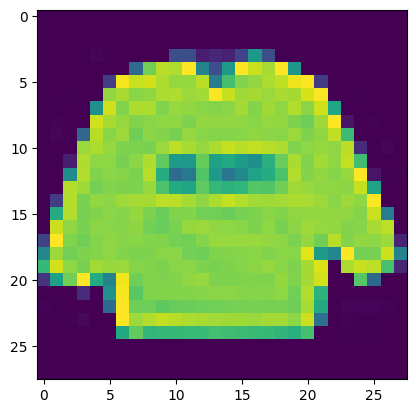

In [14]:
plt.imshow(train.iloc[0,1:].values.reshape(28,28))

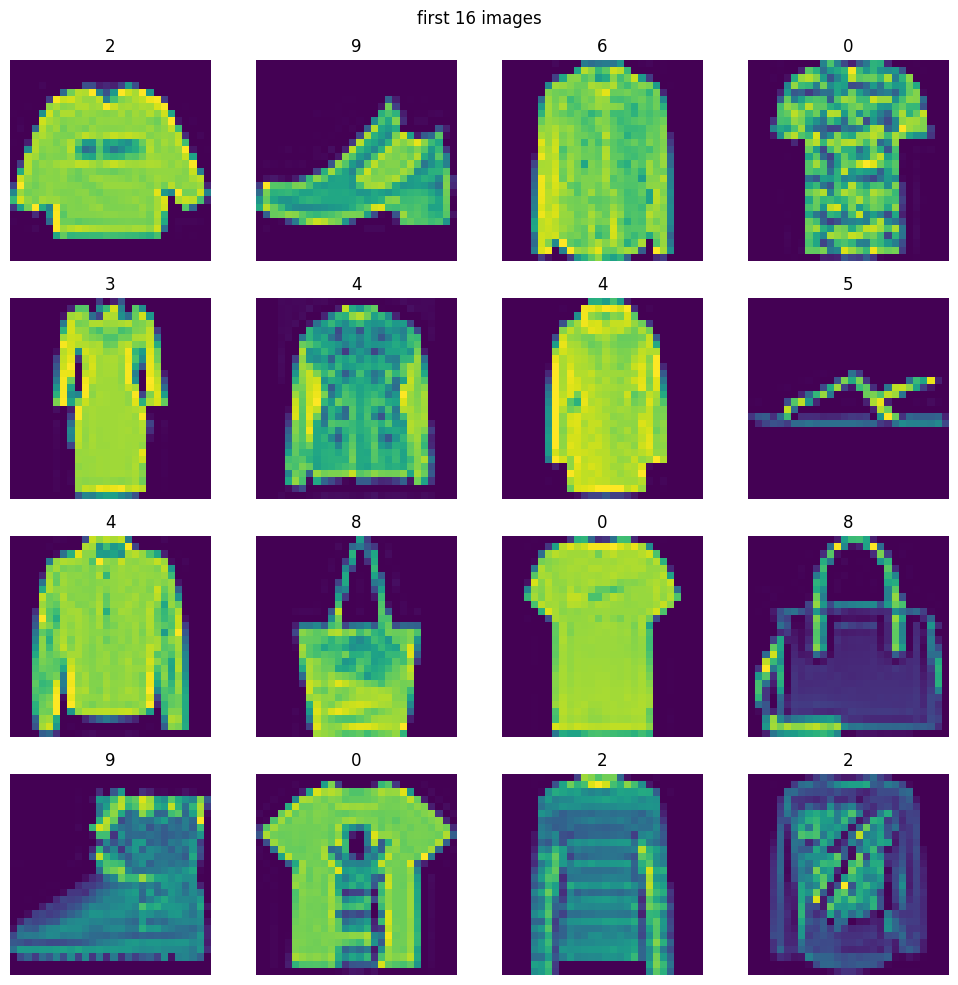

In [13]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(ncols= 4, nrows =4 ,figsize =(10,10))
fig.suptitle('first 16 images')
for i, ax in enumerate(ax.flatten()):
  img =train.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis("off")
  ax.set_title(train.iloc[i,0])
plt.tight_layout()
plt.show()

In [15]:
X = train.iloc[:, 1:].values
Y = train.iloc[: ,0 ].values
X_train, X_test ,Y_train, Y_test= train_test_split(X,Y, test_size= 0.25, random_state=40)

In [16]:
#scaleing
X_train= X_train/255.0
X_test= X_test/255.0

In [17]:
X_train_tensor= torch.tensor(X_train, dtype= torch.float32)
X_test_tensor = torch.tensor(X_test , dtype= torch.float32)
Y_train_tensor= torch.tensor(Y_train, dtype= torch.float32)
Y_test_tensor = torch.tensor(Y_test,  dtype= torch.float32)

In [18]:
type(X_train_tensor), type(X_train)

(torch.Tensor, numpy.ndarray)

In [19]:
#dataset
class CustomDataset(Dataset):
  def __init__(self, features ,label):
    self.features= torch.tensor(features, dtype= torch.float32)
    self.label   = torch.tensor(label,    dtype= torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx] ,self.label[idx]


In [20]:
#train dataset
train_dataset= CustomDataset(X_train, Y_train)
len(train_dataset)

45000

In [21]:
#test dataset
test_dataset= CustomDataset(X_test, Y_test)
len(test_dataset)

15000

In [22]:
#dataloader
train_dataloader= DataLoader(train_dataset, batch_size= 32, shuffle= True)
test_dataloader = DataLoader(test_dataset , batch_size=32, shuffle= (False))

In [27]:
train_dataloader

In [37]:
#define NN class
class NeuralNetwork(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.model= nn.Sequential(
              nn.Linear(784,128),
              nn.BatchNorm1d(128),

              nn.ReLU(),

              nn.Dropout(p=0.2),

              nn.Linear(128,64),
              nn.BatchNorm1d(64),

              nn.ReLU(),

              nn.Dropout(p=0.2),
              nn.Linear(64,10))

  def forward(self, x):
    return self.model(x)

In [38]:
lr= 0.1
epochs= 20

In [39]:
X_train.shape

(45000, 784)

In [40]:
model= NeuralNetwork(X_train.shape[1])
model.to(device)
loss_fn= nn.CrossEntropyLoss()
optimizer= optim.SGD(model.parameters(), lr= lr, weight_decay=1e-4) #regularizatin lambda



In [41]:
#training loop
for epoch in range(epochs):
  total_epoch_loss=0.0
  for batch_features, batch_labels in train_dataloader:
    batch_features, batch_labels= batch_features.to(device), batch_labels.to(device)
    outputs= model(batch_features)
    loss_value= loss_fn(outputs, batch_labels)
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

    total_epoch_loss+=loss_value.item()

  avg_epoch_loss= total_epoch_loss/len(train_dataloader)
  print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}")


Epoch [1/20], Loss: 0.5881
Epoch [2/20], Loss: 0.4643
Epoch [3/20], Loss: 0.4214
Epoch [4/20], Loss: 0.3999
Epoch [5/20], Loss: 0.3808
Epoch [6/20], Loss: 0.3664
Epoch [7/20], Loss: 0.3534
Epoch [8/20], Loss: 0.3484
Epoch [9/20], Loss: 0.3385
Epoch [10/20], Loss: 0.3308
Epoch [11/20], Loss: 0.3284
Epoch [12/20], Loss: 0.3183
Epoch [13/20], Loss: 0.3126
Epoch [14/20], Loss: 0.3083
Epoch [15/20], Loss: 0.3030
Epoch [16/20], Loss: 0.2984
Epoch [17/20], Loss: 0.2965
Epoch [18/20], Loss: 0.2892
Epoch [19/20], Loss: 0.2910
Epoch [20/20], Loss: 0.2855


In [45]:
#eval
model.eval() #turns off dropout and normalization

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [46]:
total= 0
correct= 0
with torch.no_grad():
  for batch_features, batch_labels in test_dataloader:
    outputs= model(batch_features)       #predictions
    _, predicted= torch.max(outputs, 1)     #max(pred)
    total+= batch_labels.size(0)
    correct+= (predicted==batch_labels).sum().item()

print(correct/total)


0.8870666666666667


In [47]:
total= 0
correct= 0
with torch.no_grad():
  for batch_features, batch_labels in train_dataloader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs= model(batch_features)       #predictions
    _, predicted= torch.max(outputs, 1)     #max(pred)
    total+= batch_labels.size(0)
    correct+= (predicted==batch_labels).sum().item()

print(correct/total)


0.9207777777777778
